> # Personal Expense Reports

In [2]:
from pyspark.sql.functions import *
# import seaborn as sns
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt

In [3]:
filename = 'axio_expense_report_01-01-2019_to_28-02-2023__.csv'
path = '/mnt/raw/'
filepath = path+filename

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName('Practice').getOrCreate()

In [6]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [19]:
axio_raw = spark.read.csv(filename, header=True, inferSchema = True)
axio_raw.show(10)

+----------+-------------------+--------------------+------+-----+--------------------+-------+------+----------------+--------+--------------------+
|      DATE|               TIME|               PLACE|AMOUNT|DR/CR|             ACCOUNT|EXPENSE|INCOME|        CATEGORY|    TAGS|                NOTE|
+----------+-------------------+--------------------+------+-----+--------------------+-------+------+----------------+--------+--------------------+
|2021-06-13|2023-03-18 15:11:00|         NET BANKING|545000|   DR|          Axis  7057|     No|     -|        TRANSFER|    null|                null|
|2022-10-30|2023-03-18 16:27:00|          RAZ*UPGRAD|173956|   DR|ICICI credit (MMT...|     No|     -|      \U0001f4da|    null|                null|
|2022-01-31|2023-03-18 14:32:00|             JAI SIR|168500|   CR|          Axis  7057|      -|    No|ACCOUNT TRANSFER|    null|                null|
|2022-01-31|2023-03-18 13:36:00|         NET BANKING|168500|   DR|          ICICI  838|     No|     

In [20]:
axio_raw.dtypes

[('DATE', 'string'),
 ('TIME', 'timestamp'),
 ('PLACE', 'string'),
 ('AMOUNT', 'int'),
 ('DR/CR', 'string'),
 ('ACCOUNT', 'string'),
 ('EXPENSE', 'string'),
 ('INCOME', 'string'),
 ('CATEGORY', 'string'),
 ('TAGS', 'string'),
 ('NOTE', 'string')]

In [21]:
from pyspark.sql.types import TimestampType

axio_raw = axio_raw.withColumn('TIME', trim(axio_raw['TIME'].substr(11,9)))
axio_raw = axio_raw.withColumn('TIMESTAMP', concat_ws('T', 'Date', 'Time'))
axio_raw = axio_raw.withColumn('TIMESTAMP', col('Timestamp').cast(TimestampType()))
axio_raw.show(10)


+----------+--------+--------------------+------+-----+--------------------+-------+------+----------------+--------+--------------------+-------------------+
|      DATE|    TIME|               PLACE|AMOUNT|DR/CR|             ACCOUNT|EXPENSE|INCOME|        CATEGORY|    TAGS|                NOTE|          TIMESTAMP|
+----------+--------+--------------------+------+-----+--------------------+-------+------+----------------+--------+--------------------+-------------------+
|2021-06-13|15:11:00|         NET BANKING|545000|   DR|          Axis  7057|     No|     -|        TRANSFER|    null|                null|2021-06-13 15:11:00|
|2022-10-30|16:27:00|          RAZ*UPGRAD|173956|   DR|ICICI credit (MMT...|     No|     -|      \U0001f4da|    null|                null|2022-10-30 16:27:00|
|2022-01-31|14:32:00|             JAI SIR|168500|   CR|          Axis  7057|      -|    No|ACCOUNT TRANSFER|    null|                null|2022-01-31 14:32:00|
|2022-01-31|13:36:00|         NET BANKING|1685

In [22]:
 axio_raw = axio_raw.withColumn('ACCOUNT TYPE', \
                    when(axio_raw.ACCOUNT.contains('7057'), 'BANK-AXIS-7057')\
                    .when( (axio_raw.ACCOUNT.contains('838')) \
                          | (axio_raw.ACCOUNT.contains('ICICI debit XXXX')), 'BANK-ICICI-6838')\
                    .when(axio_raw.ACCOUNT.contains('6891'), 'CREDIT-AXIS-6891')\
                    .when(axio_raw.ACCOUNT.contains('5001'), 'CREDIT-ICICI-5001')\
                    .when(axio_raw.ACCOUNT.contains('2232'), 'CREDIT-AXIS-2232')\
                    .when(axio_raw.ACCOUNT.contains('7008'), 'CREDIT-ICICI-7008')\
                    .when(axio_raw.ACCOUNT.contains('4135'), 'CREDIT-RBL-4135')\
                    .when( (axio_raw.ACCOUNT.contains('Paytm') & (axio_raw.ACCOUNT.contains('7775'))) \
                           | (axio_raw.ACCOUNT.contains('Paytm') & (axio_raw.ACCOUNT.contains('XXXX')) ), 'BANK-PAYTM-7775')\
                    .when(axio_raw.ACCOUNT.contains('4135'), 'CREDIT-RBL-4135')\
                    .when(axio_raw.ACCOUNT.contains('4636'), 'BANK-SBM-4636')\
                    .when(axio_raw.ACCOUNT.contains('CASH'), 'WALLET-WALLET-0000')\
                    .when(axio_raw.ACCOUNT.contains('Simpl'), 'CREDIT-SIMPL-8676')\
                    .when(axio_raw.ACCOUNT.contains('PAYTM Wallet'), 'WALLET-PAYTM-8676')\
                    .when(axio_raw.ACCOUNT.contains('Amazon'), 'WALLET-AMAZON-8676')\
                    .otherwise('null'))

In [23]:
axio_raw.show(30)

+----------+--------+--------------------+------+-----+--------------------+-------+------+----------------+--------+--------------------+-------------------+-----------------+
|      DATE|    TIME|               PLACE|AMOUNT|DR/CR|             ACCOUNT|EXPENSE|INCOME|        CATEGORY|    TAGS|                NOTE|          TIMESTAMP|     ACCOUNT TYPE|
+----------+--------+--------------------+------+-----+--------------------+-------+------+----------------+--------+--------------------+-------------------+-----------------+
|2021-06-13|15:11:00|         NET BANKING|545000|   DR|          Axis  7057|     No|     -|        TRANSFER|    null|                null|2021-06-13 15:11:00|   BANK-AXIS-7057|
|2022-10-30|16:27:00|          RAZ*UPGRAD|173956|   DR|ICICI credit (MMT...|     No|     -|      \U0001f4da|    null|                null|2022-10-30 16:27:00|CREDIT-ICICI-7008|
|2022-01-31|14:32:00|             JAI SIR|168500|   CR|          Axis  7057|      -|    No|ACCOUNT TRANSFER|    nul

In [24]:
axio = axio_raw.select('Timestamp', 'Account Type', 'Amount', 'DR/CR','Category', 'Place').withColumnRenamed('Account Type', 'Account').withColumnRenamed('DR/CR', 'DR_CR')
axio.dtypes

[('Timestamp', 'timestamp'),
 ('Account', 'string'),
 ('Amount', 'int'),
 ('DR_CR', 'string'),
 ('Category', 'string'),
 ('Place', 'string')]

In [25]:
axio.show(30)

+-------------------+-----------------+------+-----+----------------+--------------------+
|          Timestamp|          Account|Amount|DR_CR|        Category|               Place|
+-------------------+-----------------+------+-----+----------------+--------------------+
|2021-06-13 15:11:00|   BANK-AXIS-7057|545000|   DR|        TRANSFER|         NET BANKING|
|2022-10-30 16:27:00|CREDIT-ICICI-7008|173956|   DR|      \U0001f4da|          RAZ*UPGRAD|
|2022-01-31 14:32:00|   BANK-AXIS-7057|168500|   CR|ACCOUNT TRANSFER|             JAI SIR|
|2022-01-31 13:36:00|  BANK-ICICI-6838|168500|   DR|        TRANSFER|         NET BANKING|
|2022-09-16 07:08:00|  BANK-ICICI-6838|122960|   CR|          CREDIT|              CREDIT|
|2022-08-24 19:38:00|   BANK-AXIS-7057|121634|   CR| COMPANY BENFITS|        FISERV INDIA|
|2021-06-01 13:47:00|   BANK-AXIS-7057|104500|   DR|        TRANSFER|EASY/MAX LIFE INS...|
|2022-11-15 10:54:00|  BANK-ICICI-6838|101765|   CR|          CREDIT|             BLOCPAL|

In [26]:
axio = axio\
.withColumn('Account Type', split(axio.Account, '-')[0])\
.withColumn('Bank', split(axio.Account, '-')[1])\
.withColumn('LFD', split(axio.Account, '-')[2])\
.filter(axio.Amount>99)\
.select('Timestamp', 'Amount', 'Account Type', 'Bank', 'LFD', 'Category', 'Place', 'Account','DR_CR')

In [27]:
axio.show(30)

+-------------------+------+------------+-----+----+----------------+--------------------+-----------------+-----+
|          Timestamp|Amount|Account Type| Bank| LFD|        Category|               Place|          Account|DR_CR|
+-------------------+------+------------+-----+----+----------------+--------------------+-----------------+-----+
|2021-06-13 15:11:00|545000|        BANK| AXIS|7057|        TRANSFER|         NET BANKING|   BANK-AXIS-7057|   DR|
|2022-10-30 16:27:00|173956|      CREDIT|ICICI|7008|      \U0001f4da|          RAZ*UPGRAD|CREDIT-ICICI-7008|   DR|
|2022-01-31 14:32:00|168500|        BANK| AXIS|7057|ACCOUNT TRANSFER|             JAI SIR|   BANK-AXIS-7057|   CR|
|2022-01-31 13:36:00|168500|        BANK|ICICI|6838|        TRANSFER|         NET BANKING|  BANK-ICICI-6838|   DR|
|2022-09-16 07:08:00|122960|        BANK|ICICI|6838|          CREDIT|              CREDIT|  BANK-ICICI-6838|   CR|
|2022-08-24 19:38:00|121634|        BANK| AXIS|7057| COMPANY BENFITS|        FIS

In [16]:
months = ['s', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [17]:
axio = axio.withColumn('DAY', dayofmonth('Timestamp'))\
    .withColumn('MONTH', date_format(col('Timestamp'), 'MMMM'))\
    .withColumn('YEAR', year('Timestamp'))

In [45]:
axio.agg(sum('Amount')).show()

+-----------+
|sum(Amount)|
+-----------+
|   12837882|
+-----------+



In [47]:
axio = axio.filter( ~(axio['Category'].contains('TRANSFER')) )
axio.show()

+-------------------+------+------------+-----+----+---------------+------------+-----------------+-----+
|          Timestamp|Amount|Account Type| Bank| LFD|       Category|       Place|          Account|DR_CR|
+-------------------+------+------------+-----+----+---------------+------------+-----------------+-----+
|2022-10-30 16:27:00|173956|      CREDIT|ICICI|7008|     \U0001f4da|  RAZ*UPGRAD|CREDIT-ICICI-7008|   DR|
|2022-09-16 07:08:00|122960|        BANK|ICICI|6838|         CREDIT|      CREDIT|  BANK-ICICI-6838|   CR|
|2022-08-24 19:38:00|121634|        BANK| AXIS|7057|COMPANY BENFITS|FISERV INDIA|   BANK-AXIS-7057|   CR|
|2022-11-15 10:54:00|101765|        BANK|ICICI|6838|         CREDIT|     BLOCPAL|  BANK-ICICI-6838|   CR|
|2022-12-30 13:42:00|100000|        BANK|ICICI|6838|         CREDIT|      CREDIT|  BANK-ICICI-6838|   CR|
|2023-02-03 13:51:00|100000|        BANK|ICICI|6838|         CREDIT|      CREDIT|  BANK-ICICI-6838|   CR|
|2022-09-24 09:05:00| 77719|      CREDIT|ICICI

In [54]:
# axio = axio.withColumn('Category',  when( axio['CATEGORY'].contains('\\'), 'MISC' ).otherwise(axio['CATEGORY']) )
axio = axio.withColumn('Category',  when( (axio['CATEGORY'] == 'UNKNOWN') | (axio['CATEGORY'] == 'OTHER'), 'MISC' )\
                            .otherwise(axio['CATEGORY']) )
axio.show()

+-------------------+------+------------+-----+----+---------------+------------+-----------------+-----+
|          Timestamp|Amount|Account Type| Bank| LFD|       Category|       Place|          Account|DR_CR|
+-------------------+------+------------+-----+----+---------------+------------+-----------------+-----+
|2022-10-30 16:27:00|173956|      CREDIT|ICICI|7008|           MISC|  RAZ*UPGRAD|CREDIT-ICICI-7008|   DR|
|2022-09-16 07:08:00|122960|        BANK|ICICI|6838|         CREDIT|      CREDIT|  BANK-ICICI-6838|   CR|
|2022-08-24 19:38:00|121634|        BANK| AXIS|7057|COMPANY BENFITS|FISERV INDIA|   BANK-AXIS-7057|   CR|
|2022-11-15 10:54:00|101765|        BANK|ICICI|6838|         CREDIT|     BLOCPAL|  BANK-ICICI-6838|   CR|
|2022-12-30 13:42:00|100000|        BANK|ICICI|6838|         CREDIT|      CREDIT|  BANK-ICICI-6838|   CR|
|2023-02-03 13:51:00|100000|        BANK|ICICI|6838|         CREDIT|      CREDIT|  BANK-ICICI-6838|   CR|
|2022-09-24 09:05:00| 77719|      CREDIT|ICICI

In [66]:
axio.filter( axio['DR_CR'] == 'DR' ).groupBy('CATEGORY').agg(sum('AMOUNT').alias('Total Amount')).sort(col('Total Amount').desc()).show()

+-------------+------------+
|     CATEGORY|Total Amount|
+-------------+------------+
|        BILLS|     1131651|
|         MISC|      915316|
|     SHOPPING|      732094|
|FOOD & DRINKS|      207586|
|ENTERTAINMENT|      157901|
|       TRAVEL|      146645|
|   INVESTMENT|      131459|
|    GROCERIES|      110044|
|       HEALTH|       58728|
|          HEX|       57487|
|          EMI|       52202|
|         FUEL|       43142|
|   SETTLEMENT|       20567|
+-------------+------------+



In [56]:
axio.toPandas().to_csv('AxioReport.csv')

W:\Code\PySpark\env\lib\site-packages\pyspark\sql\pandas\conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [74]:
axio.filter(axio['Category'].contains('PAYMENT')).show(50) # .groupBy('PLACE').agg(count('Place')).show()

+-------------------+------+------------+-----+----+------------+--------------------+-----------------+-----+
|          Timestamp|Amount|Account Type| Bank| LFD|    Category|               Place|          Account|DR_CR|
+-------------------+------+------------+-----+----+------------+--------------------+-----------------+-----+
|2021-04-30 19:05:00| 40989|      CREDIT|ICICI|7008|BILL PAYMENT|CREDIT CARD BILL ...|CREDIT-ICICI-7008|   CR|
|2021-08-14 09:34:00| 36482|      CREDIT| AXIS|2232|BILL PAYMENT|CREDIT CARD BILL ...| CREDIT-AXIS-2232|   CR|
|2023-02-05 13:24:00| 32367|      CREDIT|ICICI|7008|BILL PAYMENT|CREDIT CARD BILL ...|CREDIT-ICICI-7008|   CR|
|2023-01-05 10:06:00| 31839|      CREDIT|ICICI|7008|BILL PAYMENT|CREDIT CARD BILL ...|CREDIT-ICICI-7008|   CR|
|2021-06-20 11:09:00| 31664|      CREDIT|ICICI|5001|BILL PAYMENT|CREDIT CARD BILL ...|CREDIT-ICICI-5001|   CR|
|2022-11-01 16:27:00| 31303|      CREDIT| AXIS|6891|BILL PAYMENT|CREDIT CARD BILL ...| CREDIT-AXIS-6891|   CR|
|

In [0]:
# Save reports to sql db
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession

sc = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(sc)
dbpassword = '#1Jaisirohi'
dbserver = 'sqlserver0797'
dbname = 'sqldb0797'
dbuser = 'CloudSAf58cebb8'
sql_url = 'jdbc:sqlserver://' + dbserver + '.database.windows.net:1433;database=' + dbname + ';user='+ dbuser + '@' + dbserver + ';password='+ dbpassword + ';encrypt=true;trustServerCertificate=false;hostNameInCertificate=*.database.windows.net;loginTimeout=30;'


In [121]:
schema = 'axio'

In [67]:
def writeToSQL(y):
    filename = 'report/' + 'axio_report_'+str(y)[2:]+'.csv'
    axioYY = axio.filter( year(axio.Timestamp)==y )
    try:
        axioYY.toPandas().to_csv(filename)
    except Exception as e:
        print(e)
        return 0
    else:
        print(f'File {filename} has successfully been created !')

In [68]:
years = sorted([data[0] for data in axio.groupBy(year(axio.Timestamp)).count().select('year(Timestamp)').collect()])
for i in years:
    writeToSQL(i)

W:\Code\PySpark\env\lib\site-packages\pyspark\sql\pandas\conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


File report/axio_report_19.csv has successfully been created !


W:\Code\PySpark\env\lib\site-packages\pyspark\sql\pandas\conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


File report/axio_report_20.csv has successfully been created !


W:\Code\PySpark\env\lib\site-packages\pyspark\sql\pandas\conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


File report/axio_report_21.csv has successfully been created !


W:\Code\PySpark\env\lib\site-packages\pyspark\sql\pandas\conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


File report/axio_report_22.csv has successfully been created !
File report/axio_report_23.csv has successfully been created !


W:\Code\PySpark\env\lib\site-packages\pyspark\sql\pandas\conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [0]:
tn = 'axio.axio_report_19'
axio19 = spark.read.jdbc(url=sql_url, table=tn)
axio19.display()

In [0]:
axio19.filter(axio19['DR_CR'] == 'DR')\
.groupBy('Bank')\
.sum('Amount')\
.display()

Bank,sum(Amount)
AXIS,502833
ICICI,126217
PAYTM,2359


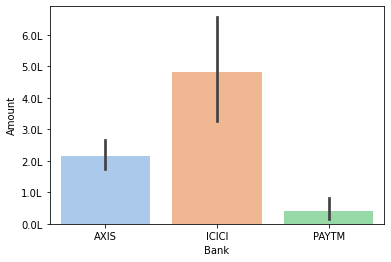

In [0]:
# axio19_Debit = axio19.toPandas()
palette = sns.color_palette('pastel')
g = sns.barplot(data=axio19_Debit, x=axio19_Debit.Bank, y=axio19_Debit.Amount, palette = palette);
# g.set(ylim= (0, 600000))
ylabels = ['{}'.format(x) + 'L' for x in g.get_yticks()/1000]
g.set_yticklabels(ylabels);
plt.savefig('/dbfs/mnt/raw/test.png')

In [0]:
axio.display()

In [0]:
axio_credits = axio.filter( (axio['Account Type']=='Credit') & (axio['DR_CR']=='DR') ).groupBy(year('timestamp')).pivot('LFD').sum('Amount').withColumnRenamed('year(timestamp)', 'Year').sort('year(timestamp)')
axio_credits_pd = axio_credits.toPandas()
axio_credits_pd.head(10)
sns.lineplot(data=axio_credits_pd, y=axio_credits_pd['6891'], x=axio_credits_pd.Year, palette = 'pastel')
sns.lineplot(data=axio_credits_pd, y=axio_credits_pd['7008'], x=axio_credits_pd.Year, palette = 'pastel')
sns.lineplot(data=axio_credits_pd, y=axio_credits_pd['2332'], x=axio_credits_pd.Year, palette = 'pastel')
sns.lineplot(data=axio_credits_pd, y=axio_credits_pd['8676'], x=axio_credits_pd.Year, palette = 'pastel')
sns.lineplot(data=axio_credits_pd, y=axio_credits_pd['4135'], x=axio_credits_pd.Year, palette = 'pastel')
# f.set(lim=(0,600000))
# axio_credits_pd.head(5)